# Домашнее задание №1 - Метод К-ближайших соседей (K-neariest neighbors)

Сегодня мы с вами реализуем наш первый алгоритм машинного обучения, метод К-ближайших соседей. Мы попытаемся решить с помощью него задачи:
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)
- регрессии (когда зависимая переменная - натуральное число)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, то нам нужно научиться подбирать этот параметр. Мы постараемся научиться пользовать numpy для векторизованных вычислений, а также посмотрим на несколько метрик, которые используются в задачах классификации и регрессии.

Перед выполнением задания:
- установите все необходимые библиотеки, запустив `pip install -r requirements.txt`

Если вы раньше не работали с numpy или позабыли его, то можно вспомнить здесь:  
http://cs231n.github.io/python-numpy-tutorial/

In [137]:
!python.exe -m pip install --upgrade pip;

In [138]:
!pip install -r requirements.txt

In [139]:
# import packages
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import sklearn
import pandas as pd

%load_ext autoreload
%autoreload 2

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from knn import KNNClassifier
from metrics import binary_classification_metrics, multiclass_accuracy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

## Задание 1. KNN на датасете Fashion-MNIST (10 баллов)

В этом задании вам предстоит поработать с картинками одежды, среди которых можно выделить 10 классов. Данные уже загружены за вас: в переменной X лежат 70000 картинок размером 28 на 28 пикселей, вытянутые в вектор размерностью 784 (28 * 28). Так как данных довольно много, а наш KNN будет весьма медленный, то возьмем случайно 1000 наблюдений (в реальности в зависимости от вашей реализации можно будет взять больше, но если будет не зватать ОЗУ, то берите меньше).

In [141]:
# download data and split on independent features and dependent variable.
X, y = fetch_openml(name="Fashion-MNIST", return_X_y=True, as_frame=False, parser='auto')
# check size of dataset
X.shape

(70000, 784)

In [142]:
# randomly take 1000 pictures to reduce running time
idx_to_stay = np.random.choice(np.arange(X.shape[0]), replace=False, size=1000)
X = X[idx_to_stay]
y = y[idx_to_stay]

In [143]:
# check size of currently dataset
X.shape, y.shape

((1000, 784), (1000,))

Давайте посмотрим на какое-нибудь изображение из наших данных:

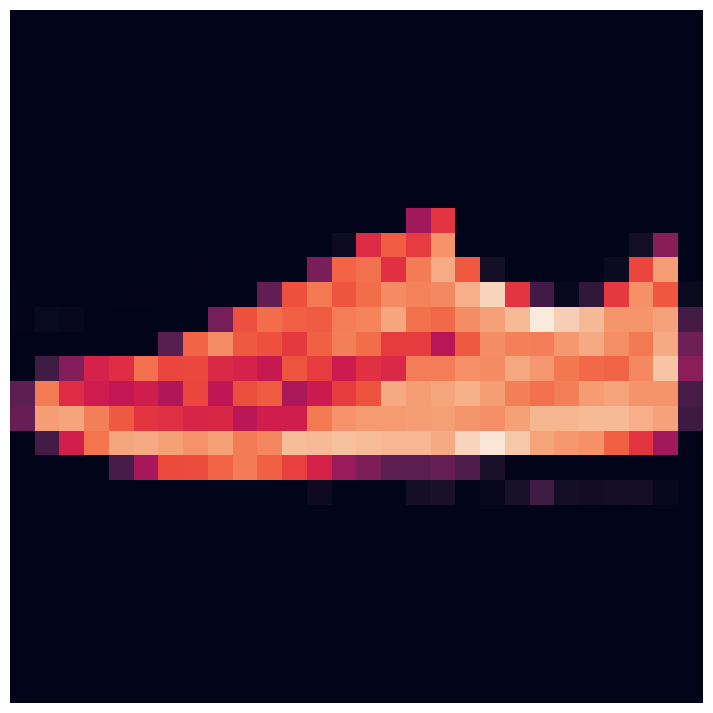

In [144]:
# возьмем случайную картинку и сделаем reshape
# 28, 28, 1 = H, W, C (число каналов, в данном случае 1)
image = X[np.random.choice(np.arange(X.shape[0]))].reshape(28, 28, 1)
plt.imshow(image)
plt.axis("off");

### 1.1. Посмотрим на все классы (0.5 баллов)

Возьмите по одной картинке каждого класса и изобразите их (например, сделайте subplots 5 на 2).

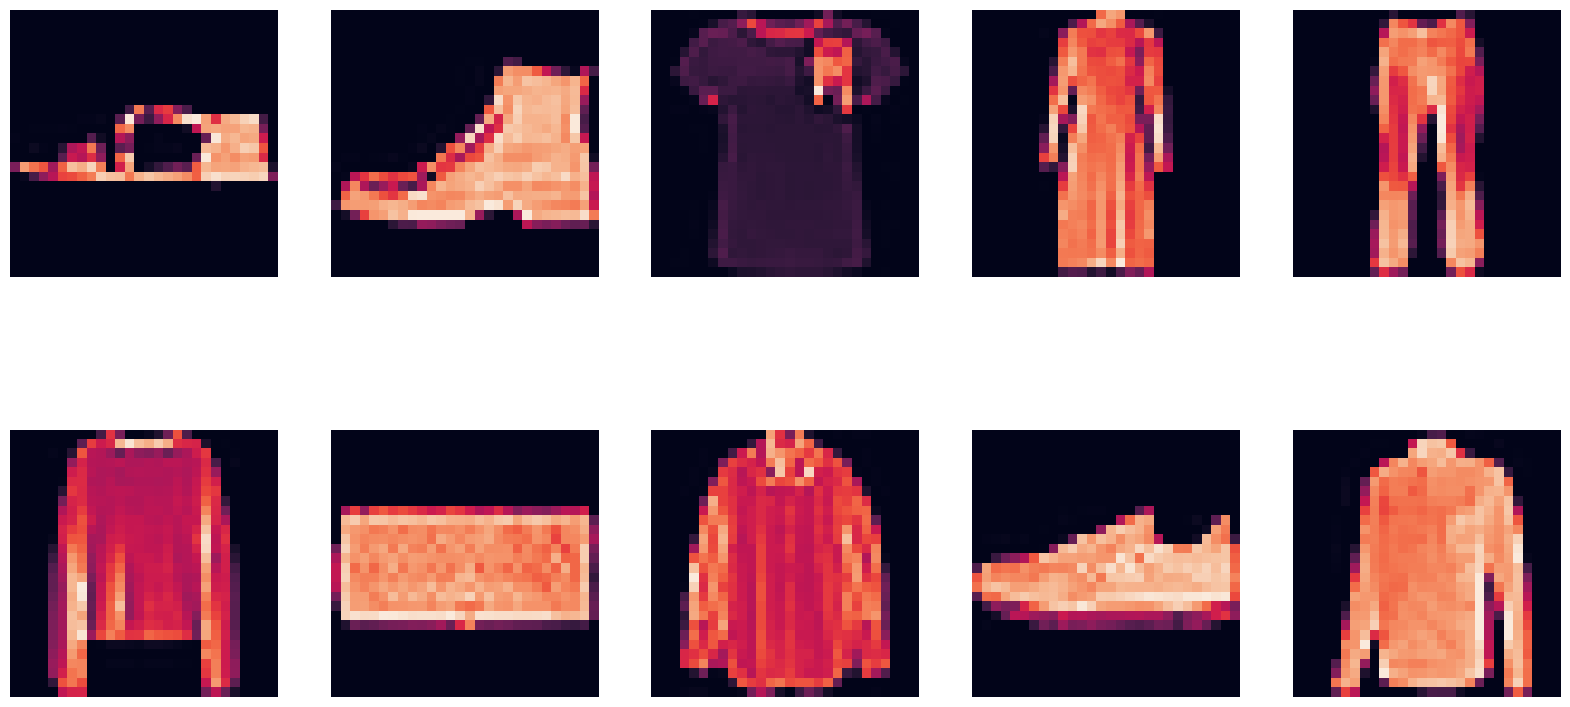

In [145]:
df_y = pd.DataFrame({'class':y})

# Load the indexes of unique images into a list
df_y_uniq = df_y.drop_duplicates()
df_y_uniq_ind = df_y_uniq.index.tolist()

images = X[df_y_uniq_ind]

# Create a figure and axis with subplots
fig, ax = plt.subplots(2, 5, figsize=(20, 10))

# Plot the images in the subplots
for i in range(5):
    ax[0, i].imshow(images[i].reshape(28, 28, 1))
    ax[0, i].axis('off')
    ax[1, i].imshow(images[i + 5].reshape(28, 28, 1))
    ax[1, i].axis('off')

# Show the figure
plt.show()


### 1.2. Сделайте небольшой EDA (1 балл)

Посмотрите на баланс классов. В дальнейших домашках делайте EDA, когда считаете нужным, он нужен почти всегда, но оцениваться это уже не будет, если не будет указано иное. Делайте EDA, чтобы узнать что-то новое о данных!

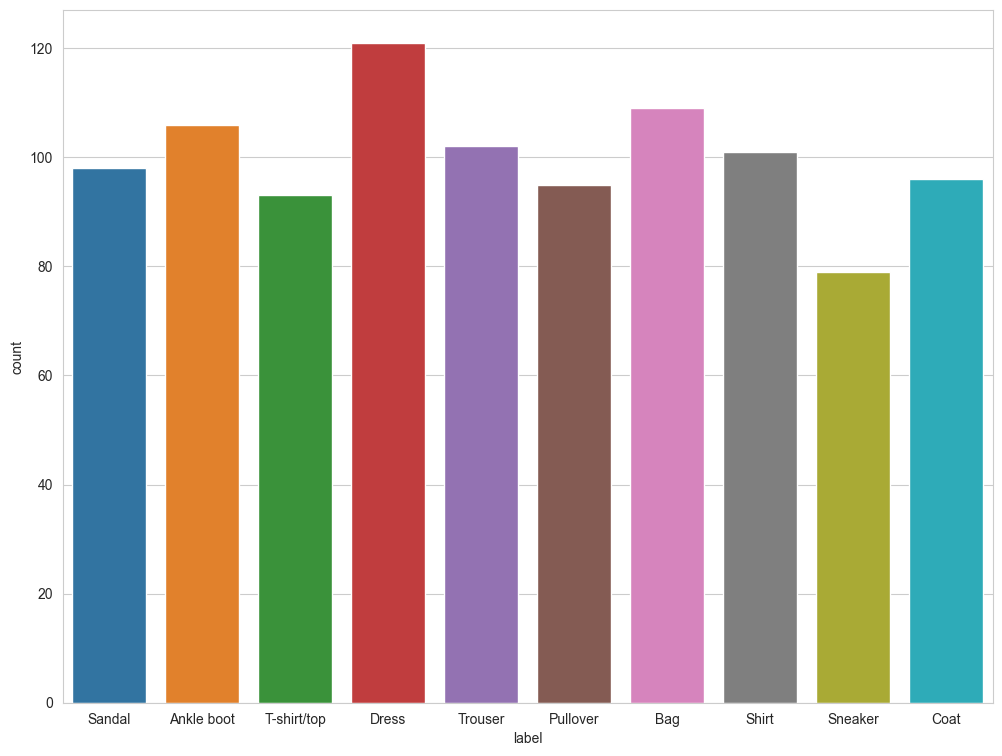

In [146]:
# Distribution of classes
# rename of classes
y_lables = {'0': 'T-shirt/top',
            '1': 'Trouser',
            '2': 'Pullover',
            '3': 'Dress',
            '4': 'Coat',
            '5': 'Sandal',
            '6': 'Shirt',
            '7': 'Sneaker',
            '8': 'Bag',
            '9': 'Ankle boot'}


df_y['label'] = df_y['class'].map(y_lables)

sns.countplot(x='label', data=df_y)
plt.show()

# Almost all classes are represented in equal numbers.

### 1.3. Разделите данные на train и test (0.5 баллов)

Разделите данные на тренировочную и тестовую выборки, размеры тестовой выборки выберите сами. Здесь вам может помочь функция `train_test_split`

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=SEED,
                                                    test_size=0.15)
X_train.shape, X_test.shape

((850, 784), (150, 784))

### 1.4. KNN для бинарной классификации (6 баллов)

Давайте возьмем для задачи бинарной классификации только объекты с метками классов 0 и 1.

In [148]:
bi_y_train_ind = np.where((y_train == '0') | (y_train == '1'))[0]
bi_y_test_ind = np.where((y_test == '0') | (y_test == '1'))[0]


binary_train_X = X_train[bi_y_train_ind]
binary_test_X = X_test[bi_y_test_ind]

binary_train_y = y_train[bi_y_train_ind]
binary_test_y = y_test[bi_y_test_ind]

print('Train data:', '\nImage numbers:',*binary_train_y.shape, ', class type:',*np.unique(binary_train_y))
print('Test data:', '\nImage numbers:',*binary_test_y.shape, ', class type:',*np.unique(binary_test_y))

Train data: 
Image numbers: 167 , class type: 0 1
Test data: 
Image numbers: 28 , class type: 0 1


И вот мы подготовили данные, но модели у нас пока что нет. В нескольких занятиях нашего курса вам придется самостоятельно реализовывать какие-то алгоритмы машинного обучения, а потом сравнивать их с готовыми библиотечными решениями. В остальных заданиях реализовывать алгоритмы будет не обязательно, но может быть полезно, поэтому часто это будут задания на дополнительные баллы, но главное не это, а понимание работы алгоритма после его реализации с нуля на простом numpy. Также это все потом можно оформить в виде репозитория ml_from_scratch и хвастаться перед друзьями.

In [149]:
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

### Настало время писать код!

В KNN нам нужно для каждого тестового примера найти расстояния до всех точек обучающей выборки. Допустим у нас 1000 примеров в train'е и 100 в test'е, тогда в итоге мы бы хотели получить матрицу попарных расстояний (например, размерностью 100 на 1000). Это можно сделать несколькими способами, и кому-то наверняка, в голову приходит идея с двумя вложенными циклами (надеюсь, что не больше:). Так можно делать, то можно и эффективнее. Вообще, в реальном KNN используется структура данных [k-d-tree](https://ru.wikipedia.org/wiki/K-d-%D0%B4%D0%B5%D1%80%D0%B5%D0%B2%D0%BE), которая позволяет производить поиск за log(N), а не за N, как будем делать мы (по сути это такое расширение бинарного поиска на многомерное пространство).

Вам нужно будет последовательно реализовать методы `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops` класса `KNN` в файле `knn.py`.

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание** Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)).

$d_{1}(\mathbf {p} ,\mathbf {q} )=\|\mathbf {p} -\mathbf {q} \|_{1}=\sum _{i=1}^{n}|p_{i}-q_{i}|$

В начале я буду иногда писать разные assert'ы, чтобы можно было проверить правильность реализации, в дальнейшем вам нужно будет их писать самим, если нужно будет проверять корректность каких-то вычислений.

In [150]:
# TODO: compute_distances_two_loops
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
np.isclose(dists[0, 50], np.sum(np.abs(binary_test_X[0] - binary_train_X[50])))

True

In [151]:
# TODO: compute_distances_one_loop
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
np.isclose(dists[0, 50], np.sum(np.abs(binary_test_X[0] - binary_train_X[50])))

True

In [152]:
# TODO: compute_distances_no_loops
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
np.isclose(dists[0, 50], np.sum(np.abs(binary_test_X[0] - binary_train_X[50])))

True

In [153]:
# knn_classifier_all = KNNClassifier(k=1)
# #
# knn_classifier_all.fit(X_train, y_train)
# #
# dists = knn_classifier_all.compute_distances_no_loops(X_train)
# dists

Проверим скорость работы реализованных методов

In [154]:
 %timeit knn_classifier.compute_distances_two_loops(binary_test_X)
 %timeit knn_classifier.compute_distances_one_loop(binary_test_X)
 %timeit knn_classifier.compute_distances_no_loops(binary_test_X)

34.5 ms ± 1.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
22.1 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
24.8 ms ± 1.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Реализуем метод для предсказания меток класса

In [155]:
# TODO: predict_labels_binary in knn.py
knn_classifier.k = 1
distances = knn_classifier.distances(binary_test_X)
prediction = knn_classifier.predict(distances)

### Метрика

Теперь нужно реализовать несколько метрик для бинарной классификации. Не забудьте подумать о численной нестабильности (деление на 0).

In [156]:
# TODO: binary_classification_metrics in metrics.py

In [157]:
precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print('Using metrics.py: \nprecision is %s, \nrecall is %s, \nf1 is %s, \naccuracy is %s'%(precision, recall, f1, accuracy))

Using metrics.py: 
precision is 1.0, 
recall is 1.0, 
f1 is 1.0, 
accuracy is 1.0


Все ли хорошо с моделью? Можно проверить свою реализацию с функциями из библиотеки `sklearn`:

<img src="https://i.imgflip.com/406fu9.jpg" width="800" height="400">

In [158]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [159]:
precision =precision_score(binary_test_y, prediction, pos_label='1')
recall =recall_score(binary_test_y, prediction, pos_label='1')
fi = f1_score(binary_test_y, prediction, pos_label='1')
accuracy = accuracy_score(binary_test_y, prediction)

print('Using sklearn:\nprecision is %s, \nrecall is %s, \nf1 is %s, \naccuracy is %s'%(precision, recall, f1, accuracy))

Using sklearn:
precision is 1.0, 
recall is 1.0, 
f1 is 1.0, 
accuracy is 1.0


### Подбор оптимального k

Чтобы подрбрать оптимальное значение параметра k можно сделать следующее: задать область допустимых значений k, например, `[1, 3, 5, 10]`. Дальше для каждого k обучить модель на тренировочных данных, сделать предсказания на тестовых и посчитать какую-нибудь метрику (метрику выберите сами исходя из задачи, но постарайтесь обосновать выбор). В конце нужно посмотреть на зависимость метрики на train'е и test'е от k и выбрать подходящее значение.

Реализуйте функцию `choose_best_k` прямо в ноутбуке.

In [160]:
def find_best_k(X_train, y_train, X_test, y_test, params, metric):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """

    train_metrics = []
    test_metrics = []
    X_mode = [X_train, X_test]
    y_mode = [y_train, y_test]
    mode_metrics = [train_metrics, test_metrics]

    knn_obj = KNNClassifier()
    knn_obj.fit(X_train, y_train)

    for i in range(len(X_mode)):
        distances = knn_obj.distances(X_mode[i]) # [0] - X_train, [1] - X_test
        for k in params:
            knn_obj.k = k
            prediction = knn_obj.predict(distances)

            try:
                metric_score = metric(y_mode[i], prediction) # [0] - y_train, [1] - y_test
            except ValueError:
                metric_score = metric(y_mode[i], prediction, pos_label='1')

            mode_metrics[i].append(metric_score) # [0] - train_metrics, [1] - test_metrics

    return train_metrics, test_metrics
    pass

In [161]:
params = [1, 2, 4, 5, 8, 10, 30]
train_metrics, test_metrics = find_best_k(binary_train_X, binary_train_y, binary_test_X, binary_test_y, params, accuracy_score)

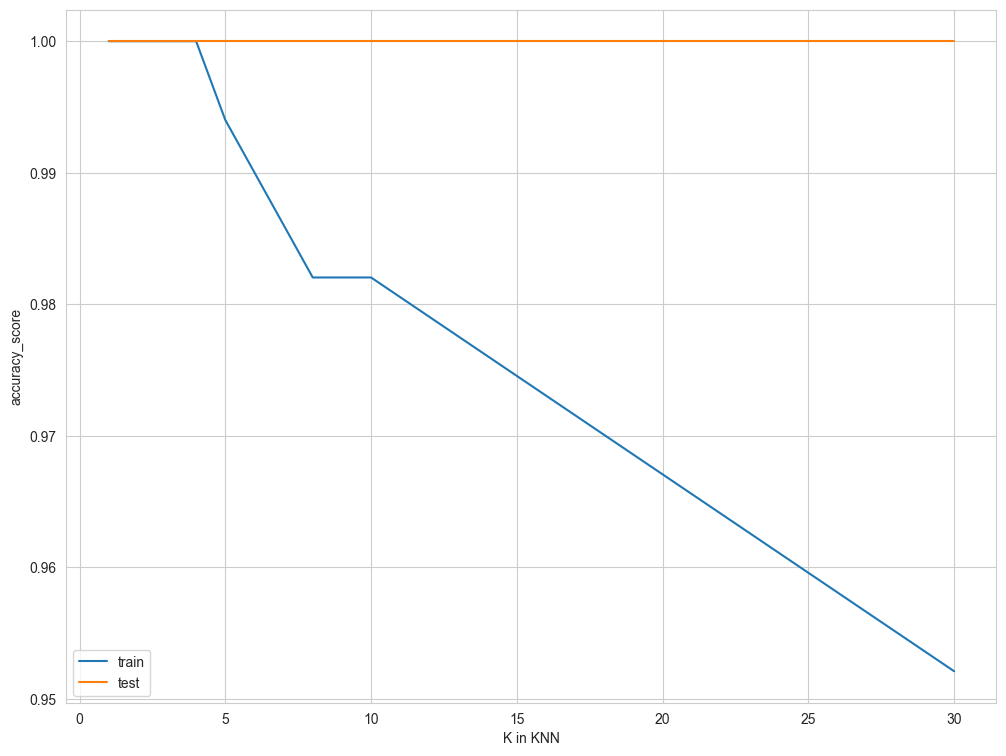

In [162]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("accuracy_score");

Заключение.
 нас задача бинарной классификации, примерно одинаковое количество данных в классах и для оценки прогноза мы не отдает предпочтение какому-то отдельному классу. Поэтому используем либо accuracy, либо f1. Accuracy незамысловат как и наша задача, а так же значения схожи с f1, поэтому используем accuracy. Гиперпараметр для тестовых данных, показывает высокую оценку для 1, 2, 4, 5, 8, 10, 30. Однако оценка снижается при k >= 4 для тренировочных данных.

На самом деле, это не самый лучший способ подбирать гиперпараметры, но способы получше мы рассмотрим в следующий раз, а пока что выберите оптимальное значение k, сделайте предсказания и посмотрите, насколько хорошо ваша модель предсказывает каждый из классов.

### 1.5. Многоклассоввая классификация (2 балла)

Теперь нужно научиться предсказывать все 10 классов. Для этого в начале напишем соответствующий метод у нашего классификатора.

In [163]:
# TODO: predict_labels_multiclass in knn.py
knn_classifier = KNNClassifier(k=5)
knn_classifier.fit(X_train, y_train)
distances = knn_classifier.distances(X_test)
predictions = knn_classifier.predict(distances)

Осталось реализовать метрику качества для многоклассовой классификации, для этого реализуйте функцию `multiclass_accuracy` в `metrics.py`.

In [164]:
# TODO: multiclass_accuracy in metrics.py
multiclass_accuracy(predictions, y_test)

0.7933333333333333

Снова выберите оптимальное значение K как мы делали для бинарной классификации.

In [165]:
params = [1, 2, 3, 5, 7, 11]
train_metrics, test_metrics = find_best_k(X_train, y_train, X_test, y_test, params, accuracy_score)

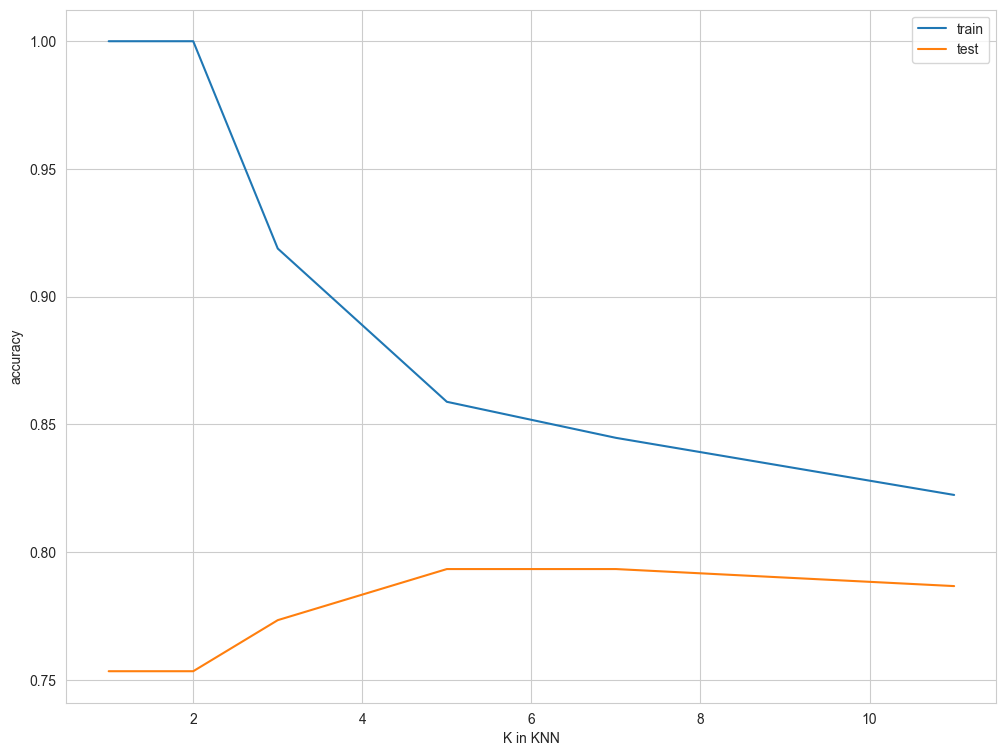

In [166]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("accuracy");

Заключение.
Оптимальным гиперпараметр k = 5. Accuracy = 0.79.

## Задание 2. KNN на датасете diabetes (10 баллов)

Теперь попробуем применить KNN к задаче регрессии. Будем работать с [данными](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) о диабете. В этом задании будем использовать класс `KNeighborsRegressor` из библиотеки `sklearn`. Загрузим необходимые библиотеки:

In [167]:
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [168]:
X, y = load_diabetes(as_frame=True, return_X_y=True)

In [169]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=SEED,
                                                    test_size=0.1)

### 2.1. EDA (2 обязательных балла + 2 доп. балла за Pipeline)

Сделайте EDA, предобработайте данные так, как считаете нужным, нужна ли в данном случае стандартизация и почему? Не забудте, что если вы стандартизуете данные, то нужно считать среднее и сдандартное отклонение на тренировочной части и с помощью них трансформировать и train, и test (**если не поняли это предложение, то обязательно разберитесь**).

**Дополнительно**:
Попробуйте разобраться с [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), чтобы можно было создать класс, который сразу проводит стандартизацию и обучает модель (или делает предсказание). Пайплайны очень удобны, когда нужно применять различные методы предобработки данных (в том числе и к разным столбцам), а также они позволяют правильно интегрировать предобработку данных в различные классы для поиска наилучших гиперпараметров модели (например, `GridSearchCV`).

In [170]:
df_X_y = pd.concat([X, y], axis=1)
df_X_y.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01,346.000000


In [171]:
df_X_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  target  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB


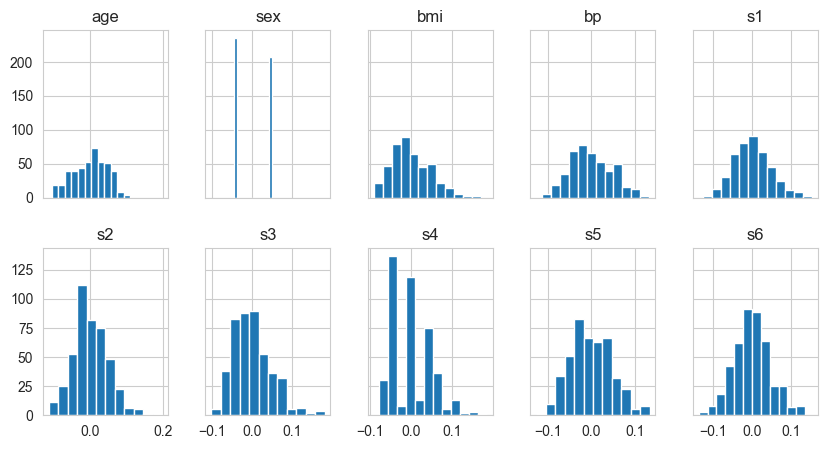

In [172]:
# Plot the images in the subplots
fig, ax = plt.subplots(2, 5, sharex='col', sharey='row',figsize=(10,5))

m=0
for i in range(2):
    for j in range(5):
        X.hist(column = X.columns[m], bins = 12, ax=ax[i,j])
        m+=1


Выше показаны гистограммы признаков, где:
* age - возраст в годах
* sex - пол
* bmi - индекс массы тела
* bp - среднее артериальное давление
* s1, tc - общий холестерин в сыворотке крови
* s2, ldl - липопротеины низкой плотности
* s3, hdl - липопротеины высокой плотности
* s4, tch - общий холестерин / ЛПВП
* s5, ltg - возможно, логарифм уровня триглицеридов в сыворотке крови
* s6, glu - уровень сахара в крови
Скачанные данные стандартизованны, их предобработка не требуется.

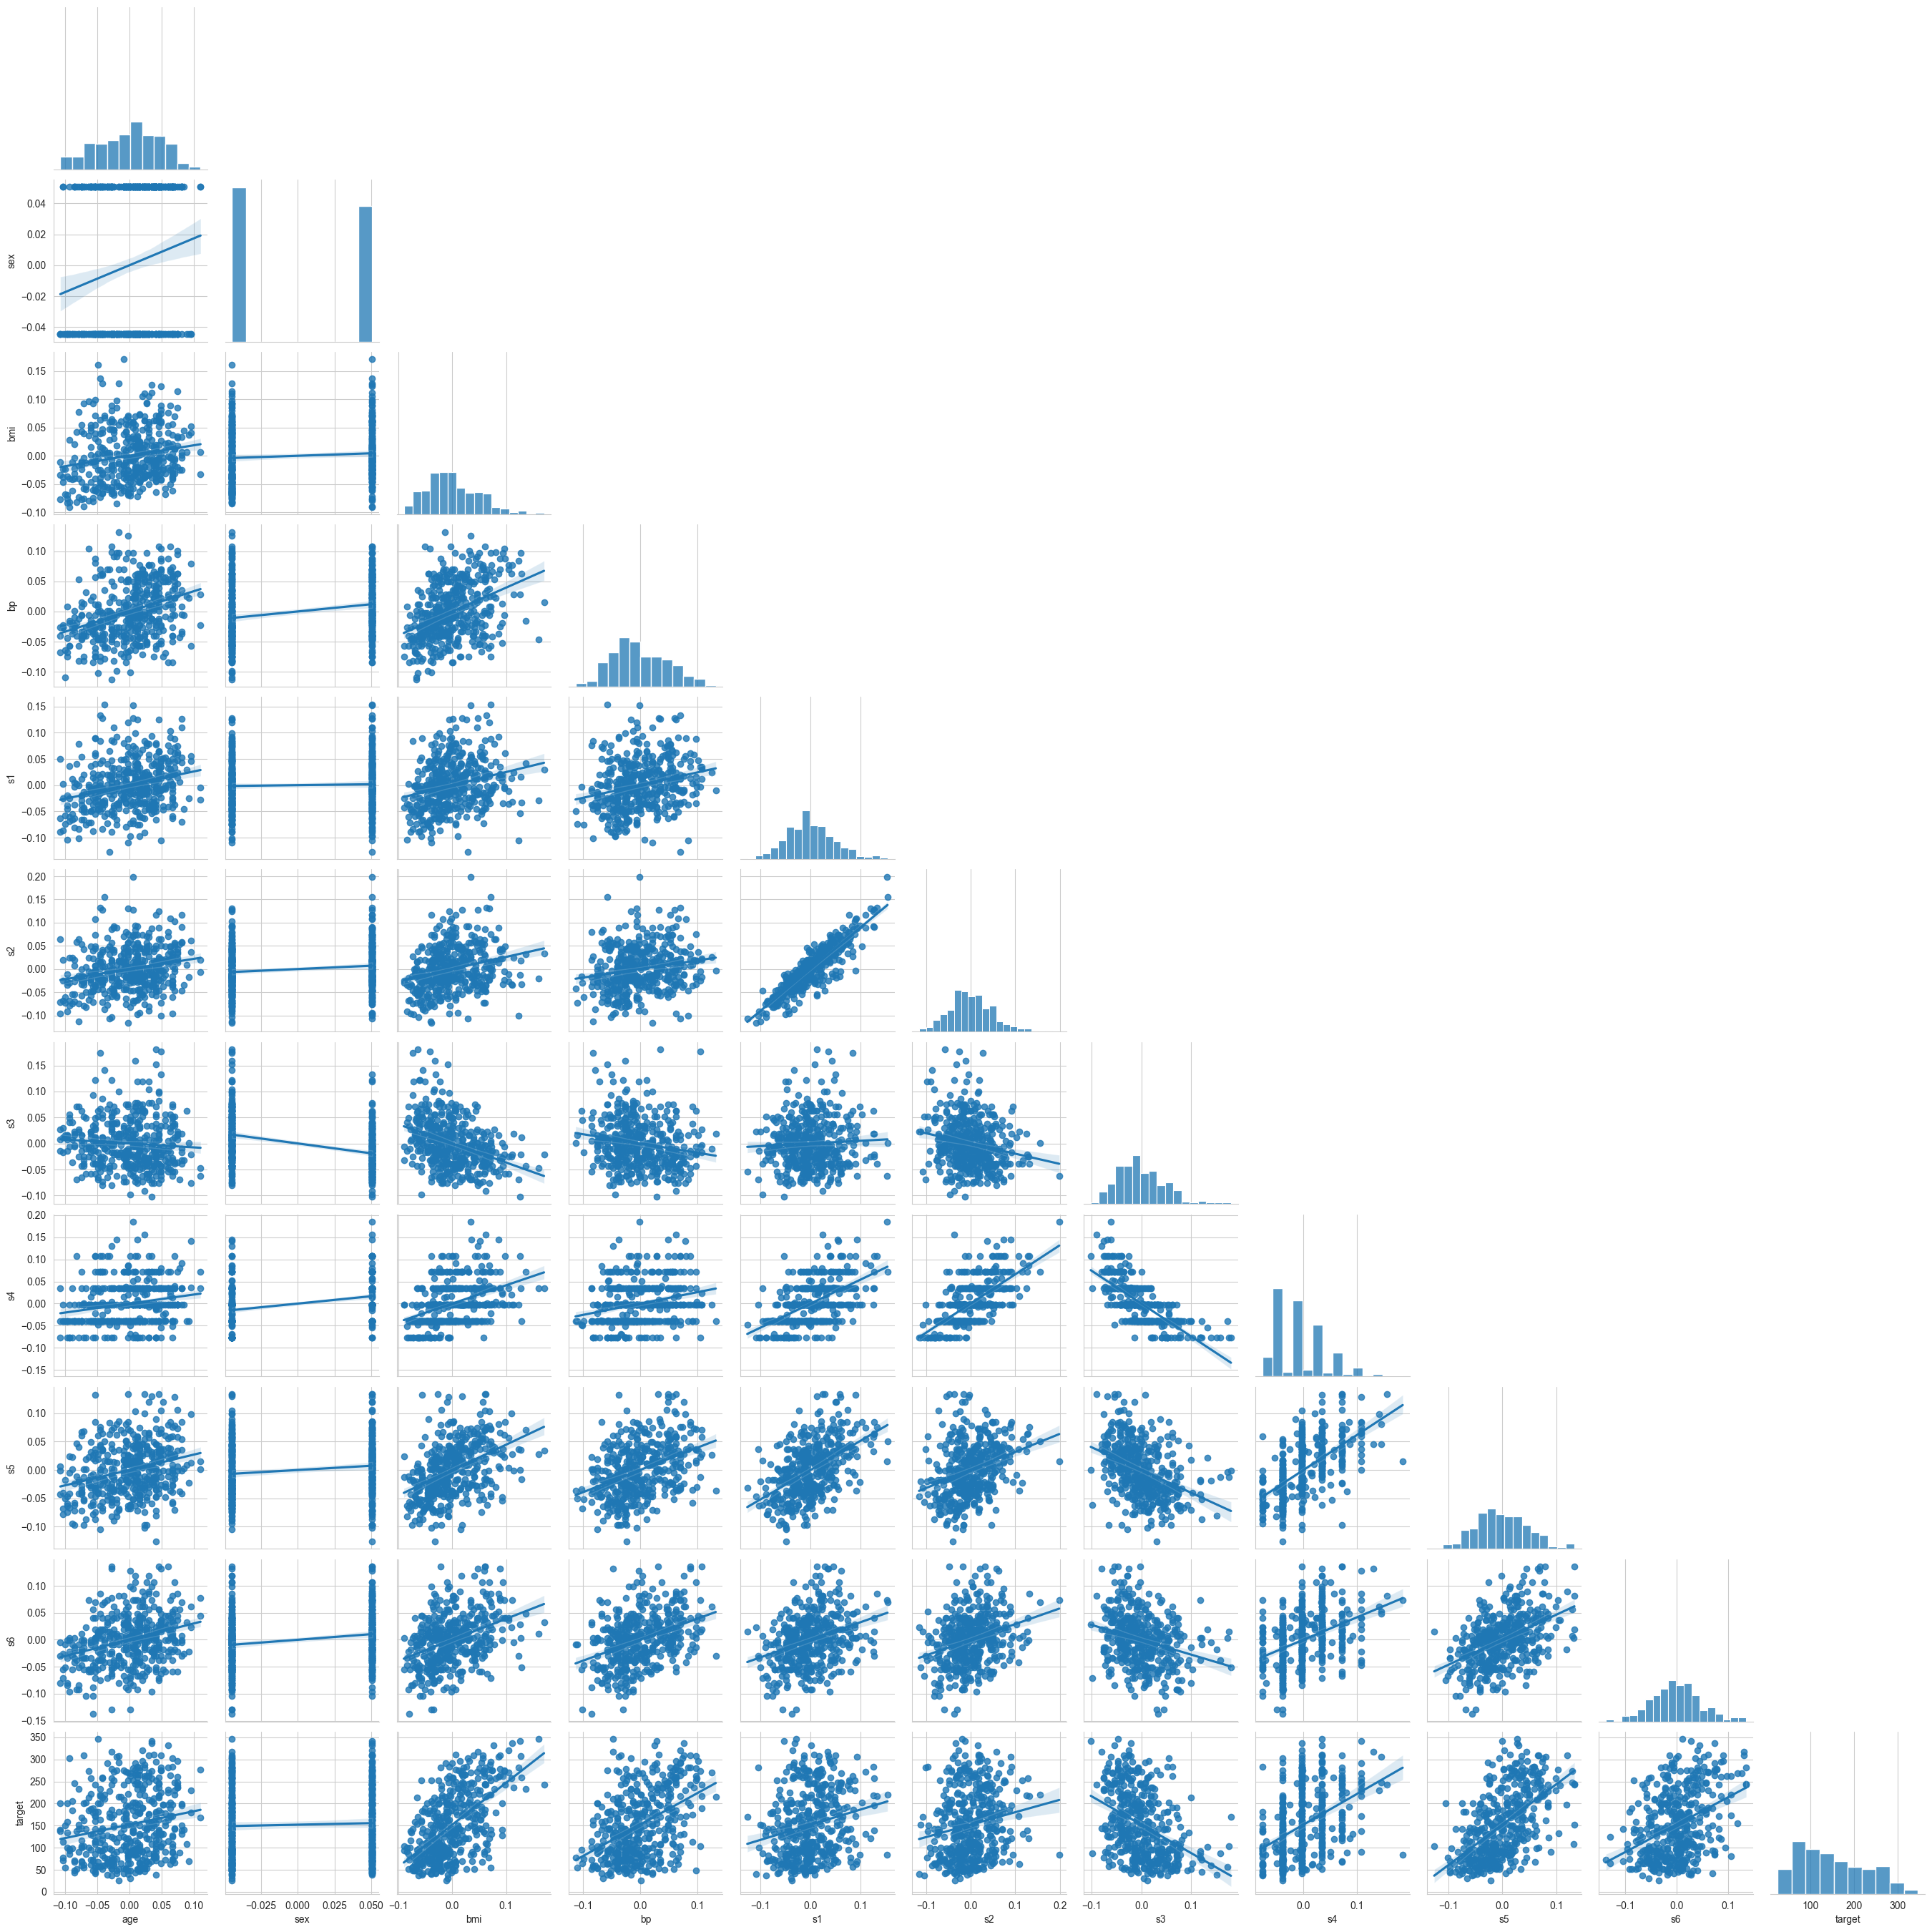

In [173]:
sns.pairplot(df_X_y, kind='reg', corner=True);

Если посмотреть попарную зависимость наших признаков, то видно, что невозможно четко описать взаимосвязь между ними, за исключением линейной зависимости между S1 и S2, S3 и S4.


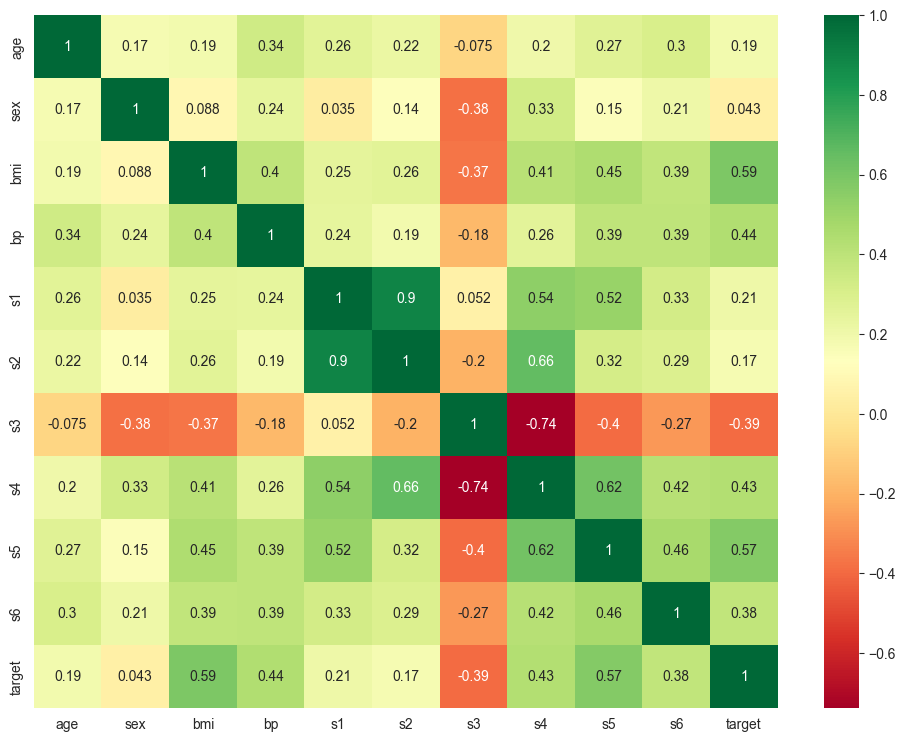

Total values =  110
sum values >= 0.5 is  14
sum values <= -0.5 is  2


In [174]:
corr = df_X_y.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corr, cmap= 'RdYlGn', annot=True)
plt.show()
print('Total values = ', corr.shape[0]*corr.shape[1] - 11)
print('sum values >= 0.5 is ',(corr >= 0.5).sum().sum() - 11)
print('sum values <= -0.5 is ',(corr <= -0.5).sum().sum())

Только 16 из 110 корреляций (без 1-ниц по диагонали) можно считать существенными (больше 0,5 или меньше -0,5)(ИМХО). Вероятно модель будет малоподходящей.

### 2.2. Регрессионная модель (1 балл)

Создайте модель `KNeighborsRegressor`, обучите ее на треноровочных данных и сделайте предсказания.

In [175]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


knn_pipeline = Pipeline(steps=[
                            ("knn_reg", KNeighborsRegressor()) # скачанные данные отшкалированы, пайпланй не нужен. Он ради доп балла :)
                        ])

param_grid = {
    'knn_reg__n_neighbors': [1, 2, 3, 5, 7, 11, 13, 17, 31]
}


grid_search = GridSearchCV(knn_pipeline, param_grid=param_grid, cv=5)

grid_search.fit(X_train, y_train)



print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


Best parameters:  {'knn_reg__n_neighbors': 13}
Best score:  0.46677954396077637


In [176]:
k = 13

knn = KNeighborsRegressor(n_neighbors=k, n_jobs=16)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(f"With k = {k} R2 = {r2_score(y_test, y_pred)}")
print(f"With k = {k} MSE = {mean_squared_error(y_test, y_pred)}")

With k = 13 R2 = 0.29780910071564415
With k = 13 MSE = 2741.986456278764


### 2.3. Метрики регресии (3 балла)

Реализуйте метрики $R^2$, MSE и  MAE в `metrics.py`. Примените их для оценки качества полученной модели. Все ли хорошо?

Напомню, что:

$R^2 = 1 - \frac{\sum_i^n{(y_i - \hat{y_i})^2}}{\sum_i^n{(y_i - \overline{y})^2}}$

$MSE = \frac{1}{n}\sum_i^n{(y_i - \hat{y_i})^2}$

$MAE = \frac{1}{n}\sum_i^n{|y_i - \hat{y_i}|}$

In [177]:
from metrics import r_squared, mae, mse

print(f"R2 = {r2_score(y_test, y_pred)}")
print(f"r_squared = {r_squared(y_pred, y_test)}")
print(f"mean_absolute_error = {mean_absolute_error(y_test, y_pred)}")
print(f"mae = {mae(y_pred, y_test)}")
print(f"mean_squared_error = {mean_squared_error(y_test, y_pred)}")
print(f"mse = {mse(y_pred, y_test)}")

R2 = 0.29780910071564415
r_squared = 0.29780910071564415
mean_absolute_error = 40.51794871794871
mae = 40.51794871794871
mean_squared_error = 2741.986456278764
mse = 2741.986456278764


### 2.4. Подбор оптимального числа соседей (2 балла)

Мы почти дошли до конца. Теперь осталось при помощи реализованных нами метрик выбрать лучшее количество соседей для нашей модели.

!!! Обратите внимание на то, что значат наши метрики, для некоторых хорошо, когда они уменьшаются, для других наоборот.

In [178]:
from metrics import r_squared, mse, mae
metric = r_squared
params = [1, 2, 3, 5, 7, 11, 13, 17, 31]

train_metrics = []
test_metrics = []
for k in params:
    knn = KNeighborsRegressor(n_neighbors=k, n_jobs=16)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_train)
    train_metrics.append(metric(y_pred, y_train))

    knn = KNeighborsRegressor(n_neighbors=k, n_jobs=16)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    test_metrics.append(metric(y_pred, y_test))


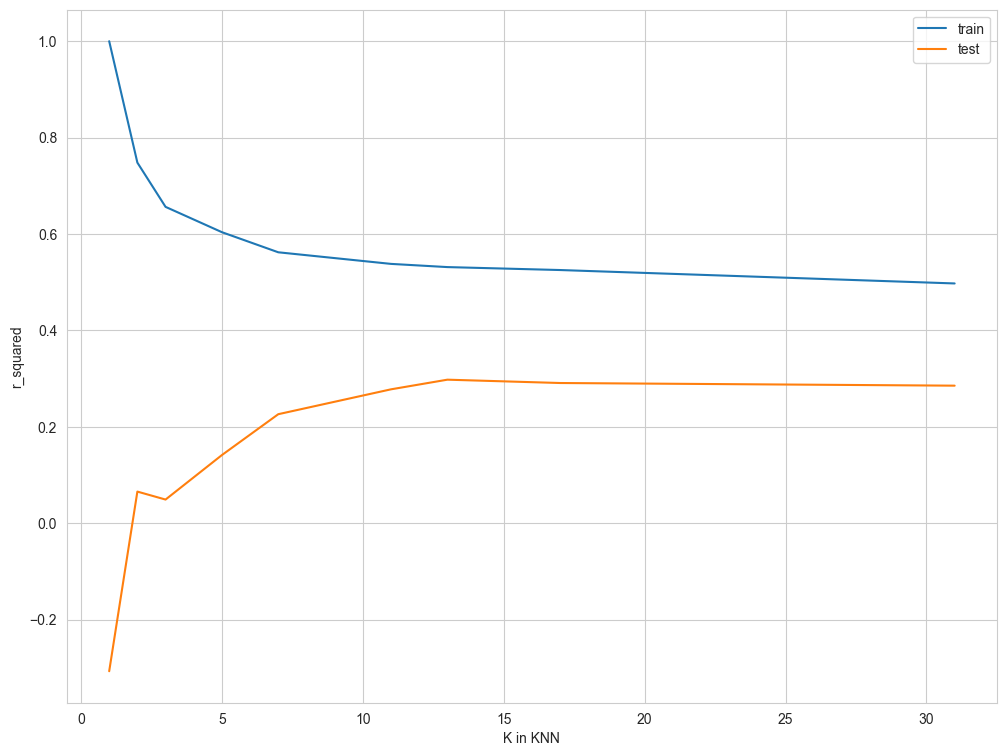

In [179]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("r_squared");

Лучшее значение k = 13

### 3. Социализация (0.5 доп. балла)

Так как у нас теперь большая группа, то было бы здорово всем познакомиться получше (так как выпускной не за горами). Соберитесь с одногруппниками в зуме (желательно, чтобы были люди и с Онлайна, и с Питера), познакомьтесь, а сюда прикрепите скриншот с камерами всех участников.

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**